In [ ]:
import requests
import numpy as np
import pandas as pd
import json
import datetime

In [ ]:
def crawl_price(stock_id):
    d = datetime.datetime.now()
    url = "https://query1.finance.yahoo.com/v8/finance/chart/"+stock_id+"?period1=0&period2="+str(int(d.timestamp()))+"&interval=1d&events=history"

    res = requests.get(url)
    data = json.loads(res.text)
    df = pd.DataFrame(data['chart']['result'][0]['indicators']['quote'][0], index=pd.to_datetime(np.array(data['chart']['result'][0]['timestamp'])*1000*1000*1000))
    return df

In [ ]:
def crawl_adjprice(stock_id):
    d = datetime.datetime.now()
    url = "https://query1.finance.yahoo.com/v8/finance/chart/"+stock_id+"?period1=0&period2="+str(int(d.timestamp()))+"&interval=1d&events=history"

    res = requests.get(url)
    data = json.loads(res.text)
    df = pd.DataFrame(data['chart']['result'][0]['indicators']['adjclose'][0]['adjclose'], index=pd.to_datetime(np.array(data['chart']['result'][0]['timestamp'])*1000*1000*1000))
    return df

In [ ]:
def crawl_global_symbol():
  url = "https://finance.yahoo.com/world-indices/"
  r = requests.get(url)
  df = pd.read_html(r.text)
  world_index = df[0]
  return world_index

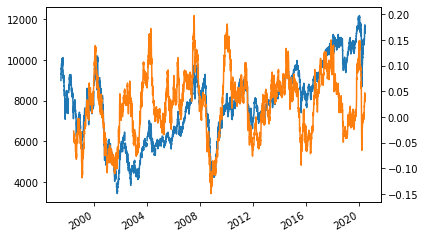

In [ ]:
close = crawl_adjprice('^TWII')[0]

mean = close.pct_change().rolling(252).mean()
std = close.pct_change().rolling(252).std()
sharpe = mean / std


close.plot()
sharpe.plot(secondary_y=True)

# df['pct_change()'] = df.pct_change()
# df['pct_manuel'] = -1 + df[0] / df[0].shift(1) 
# df['pct'] =  df[0] / df[0].shift(1) 
# df['sharpe'] = (df['pct_change()'].rolling(252).mean() / df['pct_change()'].rolling(252).std())   * (252 ** 2)
# df['sharp_diff'] = df['sharpe'].rolling(60).mean().diff()


# buy = df['sharp_diff'] > 0
# sell = df['sharp_diff'] < 0


# hold = pd.Series(np.nan, index = buy.index)
# hold[buy] = 1
# hold[sell] = -1
# df['pct'][hold==1].cumprod().plot()

In [ ]:
# !pip install backtesting
# !pip install backtrader
try:    
  from backtesting import Backtest
except ImportError:
    from pip._internal import main as pip
    pip(['install', '--user', 'backtesting'])
    pip(['install', '--user', 'backtrader'])
    from backtesting import Backtest
    from backtesting.lib import SignalStrategy
    from backtesting.test import SMA, GOOG

In [ ]:
from backtesting import Backtest
from backtesting.lib import SignalStrategy
from backtesting.test import SMA, GOOG

In [ ]:

class Strategy(SignalStrategy): 
  a = 120
  b = 0
  c = 0
  d = 1
  def init(self):
    super().init()

    close = pd.Series(self.data.Close)
    sharpe_sma = sharpe.rolling(self.a).mean()
    sharpe_sma_diff = sharpe_sma.diff()*100


    signal_long = (sharpe_sma_diff > self.b) & (sharpe_sma_diff.shift(self.d) < self.c)
    signal_short = (sharpe_sma_diff < self.c) & (sharpe_sma_diff.shift(self.d) > self.b)


    signal = signal_long    
    signal[signal_short] = -1


    
    self.set_signal(signal)
  
  def next(self):
    super().next()


df = crawl_price('^TWII').apply(lambda x : pd.to_numeric(x))
df = pd.DataFrame([df['open'], df['high'], df['low'], df['close']]).T
df = df.dropna()
df.columns = ['Open','High','Low','Close']
# df
bt = Backtest(df, Strategy)
result1 = bt.run()
bt.plot()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.


In [ ]:
result2 = bt.optimize(
    # a = range(5,200,10),
    # b =  range(1, 100, 1),
    # c = range(1,100, 1),
    d = range(5,200,10),
)
bt.plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  import sys


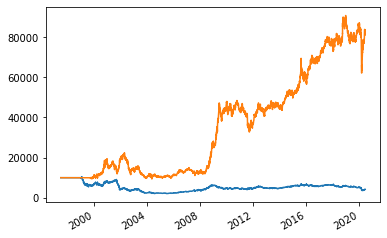

In [ ]:
result1._trade_data.Equity.plot()
result2._trade_data.Equity.plot()

In [ ]:
print(result1)
print(result2)
print(result2.loc['_strategy'])

Start                     1997-07-02 01:00:00
End                       2020-06-24 01:00:00
Duration                   8393 days 00:00:00
Exposure [%]                          92.8631
Equity Final [$]                      4173.39
Equity Peak [$]                       10447.5
Return [%]                           -58.2661
Buy & Hold Return [%]                 29.6102
Max. Drawdown [%]                    -79.7992
Avg. Drawdown [%]                    -21.7297
Max. Drawdown Duration     7814 days 00:00:00
Avg. Drawdown Duration     1958 days 00:00:00
# Trades                                  218
Win Rate [%]                          50.9174
Best Trade [%]                        50.7613
Worst Trade [%]                      -42.7914
Avg. Trade [%]                      -0.128464
Max. Trade Duration         477 days 00:00:00
Avg. Trade Duration          36 days 00:00:00
Expectancy [%]                        3.41719
SQN                                 -0.895062
Sharpe Ratio                      

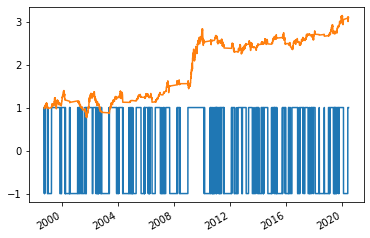

In [ ]:
# sharpe ratio 平滑
sr = sharpe
srsma = sr.rolling(60).mean()

# sharpe ratio 的斜率
srsmadiff = srsma.diff()

# 計算買入賣出點
buy = (srsmadiff > 0) & (srsmadiff.shift() < 0)
sell = (srsmadiff < 0) & (srsmadiff.shift() > 0)


# 計算持有時間
hold = pd.Series(np.nan, index=buy.index)
hold[buy] = 1
hold[sell] = -1
hold.ffill(inplace=True)
hold.plot()

# # 持有時候的績效
adj = close[buy.index]
(adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()


In [ ]:
def backtest(a, b, c, d):
    sr = sharpe
    srsma = sr.rolling(a).mean()

    srsmadiff = srsma.diff() * 100
    ub = srsmadiff.quantile(b)
    lb = srsmadiff.quantile(c)
    
    buy = ((srsmadiff.shift(d) < lb) & (srsmadiff > ub))
    sell = ((srsmadiff.shift(d) > ub) & (srsmadiff < lb))

    hold = pd.Series(np.nan, index=buy.index)
    hold[buy] = 1
    hold[sell] = 0

    hold.ffill(inplace=True)
    
    adj = twii['Adj Close'][buy.index]

    # eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()
    # hold.plot()
    eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod()
    if len(eq) > 0:
        return eq.iloc[-1]
    else:
        return 1


backtest(252,0.4,0.6,4)

In [ ]:
maxeq = 0

for a in range(100,200,20):
    for b in np.arange(0.3, 0.9, 0.03):
        for c in np.arange(0.3, 0.6, 0.03):
            for d in range(60, 180, 10):
                
                eq = backtest(a,b,c,d)
                
                if maxeq < eq:
                    maxeq = eq
                    print(eq, a,b,c,d)
